In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score, average_precision_score, accuracy_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
import csv

In [2]:
X = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/Complete_merged_feature_matrix_notes_CPT_and_ICD_.csv')

# Load y_data_pre from CSV and select relevant columns
y_data = X[['BDSPPatientID', 'annot', 'hospital']]
y = y_data['annot']


# Merge X and y based on 'BDSPPatientID'
Xy = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/Complete_merged_feature_matrix_notes_CPT_and_ICD_.csv')


In [3]:
Xy.head()

,Unnamed: 0,BDSPPatientID,ContactDate,NoteFileName,Site,CT,MRI,acut sdh_pos,brain injuri_pos,brain mri_pos,...,recent sdh_neg,resolv sdh_neg,known sdh_neg,history_sdh,ICD_I62.0,ICD_S06.5,ICD_432.1,ICD_852.2or3,annot,hospital
0,0,120109726,2019-12-01,Notes_13393227243_2508134861_20191201.txt,MGB,0,1,0,0,0,...,0,0,0,0,1,1,1,0,1,MGB
1,1,111971091,2021-05-30,Notes_13517098931_6064385669_20210530.txt,MGB,0,1,0,0,0,...,0,0,0,0,0,1,1,0,1,MGB
2,2,114651683,2022-03-09,Notes_13621620103_9363901699_20220309.txt,MGB,0,1,0,1,0,...,0,0,0,0,1,1,1,0,1,MGB
3,3,115288640,2021-03-02,Notes_13554067774_6841967671_20210302.txt,MGB,1,1,0,0,0,...,0,0,0,0,1,1,1,0,1,MGB
4,4,115389340,2019-12-02,Notes_13481394171_4791230696_20191202.txt,MGB,1,1,0,0,0,...,0,0,0,0,1,1,1,0,1,MGB


In [4]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming Xy is already defined and contains the necessary columns
X = Xy.iloc[:,:-1]
y = Xy.iloc[:,-2]
X = X.loc[:, "CT":"ICD_852.2or3"]

# Separate data by hospital
train_hospital = 'MGB'
test_hospital = 'BIDMC'

X_train = X[Xy['hospital'] == train_hospital]
y_train = y[Xy['hospital'] == train_hospital]

X_test = X[Xy['hospital'] == test_hospital]
y_test = y[Xy['hospital'] == test_hospital]

X_train = X_train.loc[:, "CT":"ICD_852.2or3"]
X_test = X_test.loc[:, "CT":"ICD_852.2or3"]

# Initialize variables for storing results
all_predictions = []
all_true_labels = []
all_row_numbers = []
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
predictions = []
roc_curves = []
pr_curves = []
feature_importances_dict = {feature: [] for feature in X.columns}

# Define and fit the model
model = RandomForestClassifier(
    n_estimators=100,
    random_state=2023,
    n_jobs=-1
)
search_spaces = {
    'n_estimators': (10, 200),
    'max_depth': (2, 10),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
}
model_cv = BayesSearchCV(
    model,
    search_spaces,
    n_iter=50,
    scoring='roc_auc',
    n_jobs=47,
    cv=10,
    random_state=2023
)
model_cv.fit(X_train, y_train)
model = model_cv.best_estimator_

# Predict and evaluate
ytr_pred = model.predict_proba(X_train)[:, 1]
yte_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, cutoffs = roc_curve(y_train, ytr_pred)
best_cutoff = cutoffs[np.argmax(tpr - fpr)]
yte_pred_bin = (yte_pred > best_cutoff).astype(int)
auc_cv.append(roc_auc_score(y_test, yte_pred))
f1_cv.append(f1_score(y_test, yte_pred_bin))
cf_cv.append(confusion_matrix(y_test, yte_pred_bin))
predictions.append(yte_pred_bin)

# Save the model
model_filename = 'model_train_BIDMC_MGB_test_RF__best_model.pickle'
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model, 'cutoff': best_cutoff}, f)

# Compute ROC and PR curves
fpr, tpr, cutoffs = roc_curve(y_test, yte_pred)
all_predictions.extend(yte_pred_bin)
all_true_labels.extend(y_test)
all_row_numbers.extend(Xy[Xy['hospital'] == test_hospital]['BDSPPatientID'])
roc_curves.append((fpr, tpr, roc_auc_score(y_test, yte_pred)))
precision, recall, thresholds = precision_recall_curve(y_test, yte_pred)
pr_curves.append((recall, precision, auc(recall, precision)))
auc_pr_loop = auc(recall, precision)
auc_pr.append(auc_pr_loop)
feature_importances = model.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
    feature_importances_dict[feature].append(importance)

# Print feature importances
print("Feature importances for this fold:")
print(pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False))

print(auc_cv)
print(auc_pr)

# Save predictions to CSV
df_pred = pd.DataFrame(data={
    'BDSPPatientID': Xy[Xy['hospital'] == test_hospital]['BDSPPatientID'].values,
    'y': y_test.values,
    'y_pred': yte_pred_bin,
    'y_pred_proba': yte_pred
})
df_pred.to_csv('BI_y_and_y_pred.csv', index=False)


/home/gregory178/Desktop/NAX project/.conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Feature importances for this fold:
             Feature  Importance
24           sdh_pos    0.238620
68         ICD_S06.5    0.155463
69         ICD_432.1    0.115550
21  neurosurgeri_pos    0.086349
25        subdur_pos    0.045790
..               ...         ...
64    resolv sdh_neg    0.000000
39   craniectomi_neg    0.000000
37     burr hole_neg    0.000000
34      acut sdh_neg    0.000000
52           mvc_neg    0.000000

[71 rows x 2 columns]
[0.970837687459358]
[0.8312369127417338]


In [5]:
X_train = X_train.loc[:, "CT":"ICD_852.2or3"]
X_train.head()

,CT,MRI,acut sdh_pos,brain injuri_pos,brain mri_pos,burr hole_pos,stabl sdh_pos,craniectomi_pos,craniotomi_pos,ct head_pos,...,trauma_neg,prior sdh_neg,recent sdh_neg,resolv sdh_neg,known sdh_neg,history_sdh,ICD_I62.0,ICD_S06.5,ICD_432.1,ICD_852.2or3
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,1,0
3,1,1,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,1,1,1,0
4,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,1,0


In [6]:
print(auc_cv)
print(auc_pr)

#Last Draft:
# [0.970837687459358]
# [0.8312369127417338]




[0.970837687459358]
[0.8312369127417338]


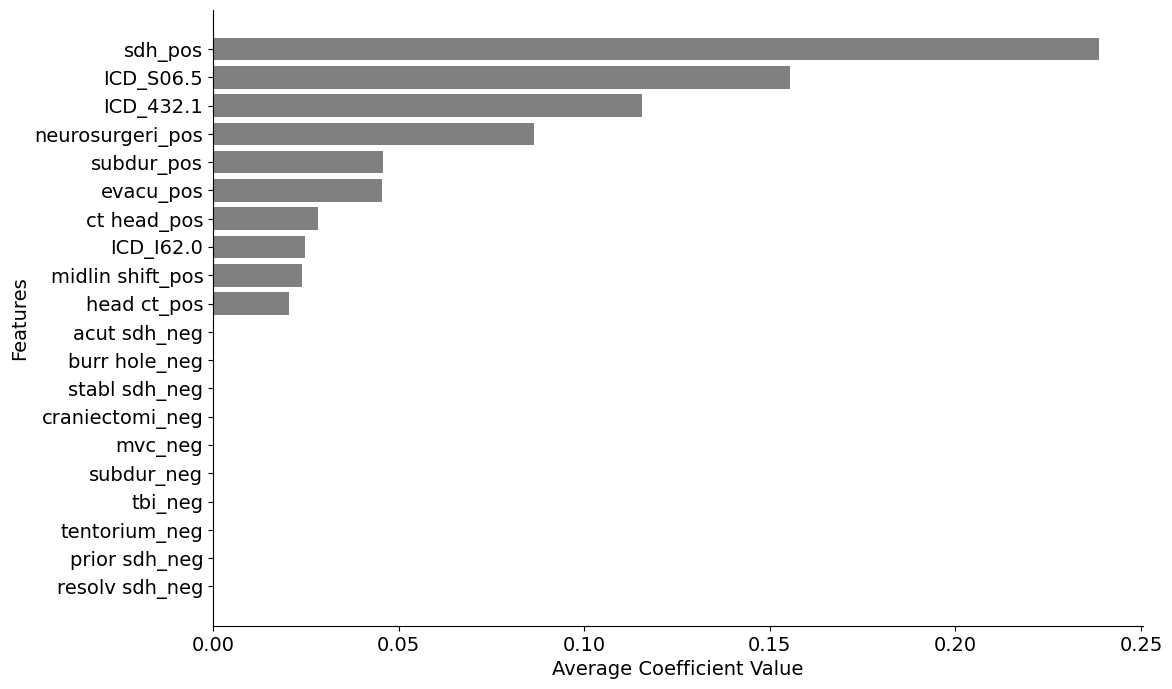

In [7]:
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Save to CSV
feature_importances_df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_trainMGB_testBIDMC_feat_importances_.csv', index=False)

# Aggregate feature importances by averaging over folds
avg_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importances_dict.items()}
sorted_features = sorted(avg_feature_importances.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_features)

# Select top 10 and bottom 10 features
top_features = features[:10]
top_importances = importances[:10]
bottom_features = features[-10:]
bottom_importances = importances[-10:]

# Combine top and bottom features for plotting
plot_features = top_features + bottom_features
plot_importances = top_importances + bottom_importances

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='grey')  # Set bar color to grey
plt.xlabel('Average Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)  # Set y-axis label
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.gca().spines['top'].set_visible(False)  # Remove top border
plt.gca().spines['right'].set_visible(False)  # Remove right border
plt.xticks(fontsize=14)  # Set x-axis tick label font size
plt.yticks(fontsize=14)  # Set y-axis tick label font size
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_trainMGB_testBIDMC_feat_importances_.png')
plt.show()

In [8]:
def bootstrap_resample(y_true, y_pred_proba, y_pred, n_iterations=1000, alpha=0.95):
    aucs = []
    f1s = []
    precisions = []
    recalls = []
    accuracies = []
    specificities = []
    auc_prs = []
    roc_curves = []
    pr_curves = []
    n_size = len(y_true)
    for _ in range(n_iterations):
        indices = np.random.randint(0, n_size, n_size)
        if len(np.unique(y_true[indices])) < 2:
            continue  # skip this resample if it does not have both classes
        y_true_resampled = y_true[indices]
        y_pred_proba_resampled = y_pred_proba[indices]
        y_pred_resampled = y_pred[indices]

        # Calculate metrics
        aucs.append(roc_auc_score(y_true_resampled, y_pred_proba_resampled))
        f1s.append(f1_score(y_true_resampled, y_pred_resampled))
        precisions.append(average_precision_score(y_true_resampled, y_pred_resampled))
        recalls.append(recall_score(y_true_resampled, y_pred_resampled))
        accuracies.append(accuracy_score(y_true_resampled, y_pred_resampled))
        
        # Compute specificity
        tn, fp, fn, tp = confusion_matrix(y_true_resampled, y_pred_resampled).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
        
        # Compute AUC-PR
        precision, recall, _ = precision_recall_curve(y_true_resampled, y_pred_proba_resampled)
        auc_prs.append(auc(recall, precision))
        
        # Compute ROC and PR curves
        fpr, tpr, _ = roc_curve(y_true_resampled, y_pred_proba_resampled)
        roc_curves.append((fpr, tpr))
        pr_curves.append((precision, recall))
    
    # Calculate confidence intervals
    lower_p = ((1.0 - alpha) / 2.0) * 100
    upper_p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    auc_ci = np.percentile(aucs, [lower_p, upper_p])
    f1_ci = np.percentile(f1s, [lower_p, upper_p])
    precision_ci = np.percentile(precisions, [lower_p, upper_p])
    recall_ci = np.percentile(recalls, [lower_p, upper_p])
    accuracy_ci = np.percentile(accuracies, [lower_p, upper_p])
    specificity_ci = np.percentile(specificities, [lower_p, upper_p])
    auc_pr_ci = np.percentile(auc_prs, [lower_p, upper_p])
    
    return auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, specificity_ci, auc_pr_ci, roc_curves, pr_curves


In [14]:
# Perform bootstrap resampling to get confidence intervals
auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, specificity_ci, auc_pr_ci, roc_curves_bootstrap, pr_curves_bootstrap = \
    bootstrap_resample(y_test.values, yte_pred, yte_pred_bin)


In [15]:
# Calculate confidence intervals for ROC
roc_fpr_interp = np.linspace(0, 1, 100)
roc_tpr_interp = [np.interp(roc_fpr_interp, fpr, tpr) for fpr, tpr in roc_curves_bootstrap]
roc_mean_tpr = np.mean(roc_tpr_interp, axis=0)
roc_lower_tpr = np.percentile(roc_tpr_interp, 2.5, axis=0)
roc_upper_tpr = np.percentile(roc_tpr_interp, 97.5, axis=0)

# Calculate confidence intervals for PR
pr_recall_interp = np.linspace(0, 1, 100)
pr_precision_interp = [np.interp(pr_recall_interp, recall[::-1], precision[::-1]) for precision, recall in pr_curves_bootstrap]
pr_mean_precision = np.mean(pr_precision_interp, axis=0)
pr_lower_precision = np.percentile(pr_precision_interp, 2.5, axis=0)
pr_upper_precision = np.percentile(pr_precision_interp, 97.5, axis=0)


0.970837687459358
[0.8312369127417338]
0.2995169082125604
AUC_Roc: 0.9708 (95% CI: 0.9628 - 0.9781)
AUC_PRC: 0.8312 (95% CI: 0.7791 - 0.8823)


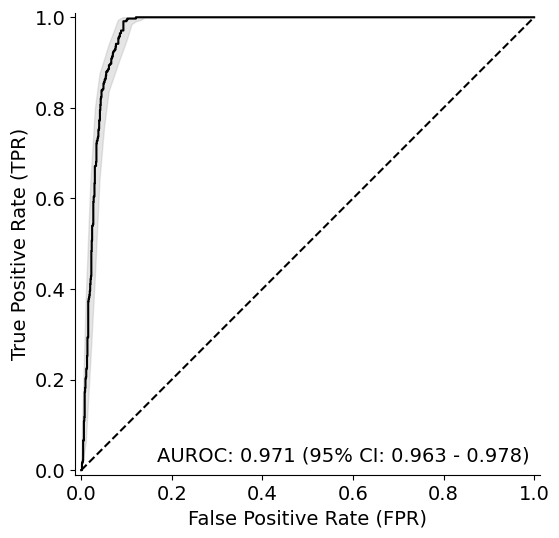

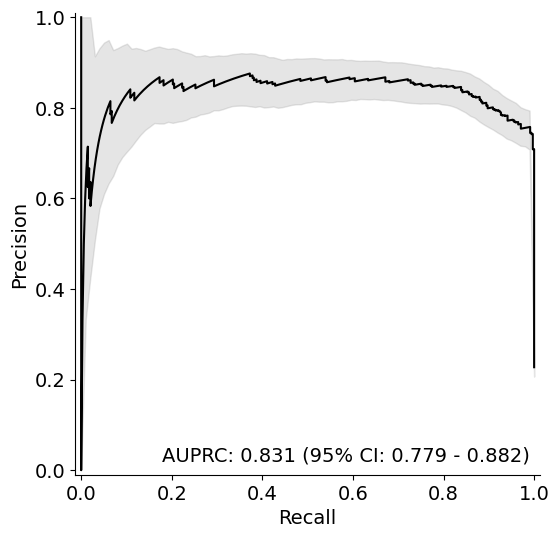

In [20]:
# Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

# Save the DataFrame to a CSV file
results_df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_LR_iter_pred_BIDMC_.csv', index=False)

# Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)
prc_final=np.mean(auc_pr)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
# df['C'] = final_Cs
# df['l1_ratio'] = final_l1
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df_pred = pd.concat([df1]).reset_index()
df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_LR_iter_BIDMC_.csv')

# Print final Data
print(auc_final)
print(auc_pr)
print(f1_final)

print(f"AUC_Roc: {auc_final:.4f} (95% CI: {auc_ci[0]:.4f} - {auc_ci[1]:.4f})")
print(f"AUC_PRC: {prc_final:.4f} (95% CI: {auc_pr_ci[0]:.4f} - {auc_pr_ci[1]:.4f})")



# Plot all ROC curves overlayed on a single graph
plt.figure(figsize=(6, 6))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.fill_between(roc_fpr_interp, roc_lower_tpr, roc_upper_tpr, color='grey', alpha=0.2)
for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, color='black')  # Removed legend label
plt.text(0.99, 0.01, f"AUROC: {auc_final:.3f} (95% CI: {auc_ci[0]:.3f} - {auc_ci[1]:.3f})", ha='right', va='bottom', fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axis('equal')
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_AUC_iter_BIDMC_.png')
plt.show()

# Plot all PR curves overlayed on a single graph
plt.figure(figsize=(6, 6))
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.fill_between(pr_recall_interp, pr_lower_precision, pr_upper_precision, color='grey', alpha=0.2)
plt.plot(recall, precision, color='black')  # Removed legend label
plt.text(0.99, 0.01, f"AUPRC: {prc_final:.3f} (95% CI: {auc_pr_ci[0]:.3f} - {auc_pr_ci[1]:.3f})", ha='right', va='bottom', fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axis('equal')
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_PR_iter_BIDMC_.png')
plt.show()
